In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,plot_importance, plot_tree
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from scipy.stats import entropy
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

In [127]:
crop = pd.read_excel(r"E:\Data science\DataHack\Skillenza\Stage 5 Level 3\train.xlsx")
crop_test = pd.read_excel(r"E:\Data science\DataHack\Skillenza\Stage 5 Level 3\test.xlsx")
sub = pd.read_csv(r"E:\Data science\DataHack\Skillenza\Stage 5 Level 3\Submission_cropstatus.csv")

In [128]:
crop.head()

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,Crop_status
0,1,188,Feed,clay,1,0,0.0,0,1,0
1,2,209,Feed,clay,1,0,0.0,0,2,1
2,3,257,Feed,clay,1,0,0.0,0,2,1
3,4,257,Feed,silt,1,0,0.0,0,2,1
4,5,342,Feed,clay,1,0,0.0,0,2,1


In [129]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          80000 non-null  int64  
 1   Insects                     80000 non-null  int64  
 2   Crop                        80000 non-null  object 
 3   Soil                        80000 non-null  object 
 4   Category_of_Toxicant        80000 non-null  int64  
 5   Does_count                  80000 non-null  int64  
 6   Number_of_Weeks_Used        71945 non-null  float64
 7   Number_Weeks_does_not used  80000 non-null  int64  
 8   Season                      80000 non-null  int64  
 9   Crop_status                 80000 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ MB


In [130]:
crop.isnull().mean()

ID                            0.000000
Insects                       0.000000
Crop                          0.000000
Soil                          0.000000
Category_of_Toxicant          0.000000
Does_count                    0.000000
Number_of_Weeks_Used          0.100687
Number_Weeks_does_not used    0.000000
Season                        0.000000
Crop_status                   0.000000
dtype: float64

In [131]:
crop['is_train'] = 1
crop_test['is_train'] = 0

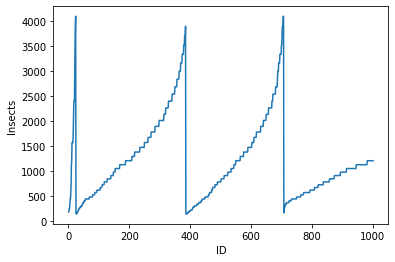

In [7]:
sns.lineplot(crop.ID.loc[0:1000] , crop.Insects.loc[0:1000])

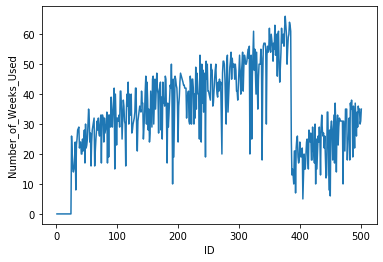

In [8]:
sns.lineplot(crop.ID.loc[0:500] , crop.Number_of_Weeks_Used.loc[0:500])

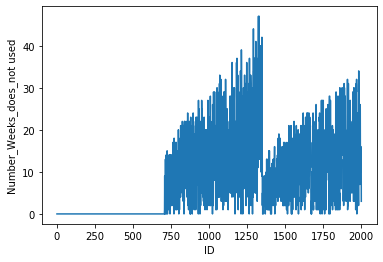

In [9]:
sns.lineplot(crop.ID.loc[0:2000] , crop['Number_Weeks_does_not used'].loc[0:2000])

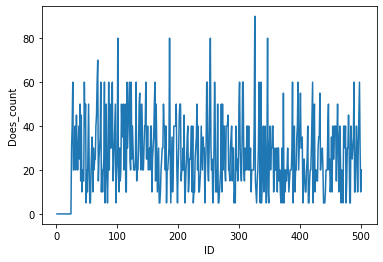

In [10]:
sns.lineplot(crop.ID.loc[0:500] , crop['Does_count'].loc[0:500])

In [163]:
full_df = pd.concat([crop,crop_test] , axis = 0 , ignore_index = True)
full_df.head(2)

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,Crop_status,is_train
0,1,188,Feed,clay,1,0,0.0,0,1,0.0,1
1,2,209,Feed,clay,1,0,0.0,0,2,1.0,1


## Categorical Variables

In [164]:
cat = ['Category_of_Toxicant' , 'Season' , 'Crop_status','Crop' ,'Soil']

In [165]:
# Check for cardinality
# How many categories each feature is having.
for cols in cat:
    print("The feature is ",cols," And the no. of categories are ",len(full_df[cols].unique()))
    print(full_df[cols].value_counts())

The feature is  Category_of_Toxicant  And the no. of categories are  3
2    81953
3    31926
1     1121
Name: Category_of_Toxicant, dtype: int64
The feature is  Season  And the no. of categories are  3
2    57147
1    34770
3    23083
Name: Season, dtype: int64
The feature is  Crop_status  And the no. of categories are  4
0.0    66716
1.0    11183
2.0     2101
Name: Crop_status, dtype: int64
The feature is  Crop  And the no. of categories are  2
Food    82374
Feed    32626
Name: Crop, dtype: int64
The feature is  Soil  And the no. of categories are  2
clay    62655
silt    52345
Name: Soil, dtype: int64


In [166]:
# Missing values treatment
# ************************

mean2 = round(crop['Number_of_Weeks_Used'][crop.Category_of_Toxicant == 2].mean(),3)
mean3 = round(crop['Number_of_Weeks_Used'][crop.Category_of_Toxicant == 3].mean(),3)


full_df['Number_of_Weeks_Used'][full_df.Category_of_Toxicant == 1] = full_df['Number_of_Weeks_Used'][full_df.Category_of_Toxicant == 1].fillna(0)
full_df['Number_of_Weeks_Used'][full_df.Category_of_Toxicant == 2] = full_df['Number_of_Weeks_Used'][full_df.Category_of_Toxicant == 2].fillna(mean2)
full_df['Number_of_Weeks_Used'][full_df.Category_of_Toxicant == 3] = full_df['Number_of_Weeks_Used'][full_df.Category_of_Toxicant == 3].fillna(mean3)

In [ ]:
# Label Encoding
features = ['Crop','Soil']
le = LabelEncoder()
full_df[features] = full_df[features].apply(le.fit_transform)

In [135]:
# Mean Encoding

def mean_enc(dataframe,train,feature,Tar_feature):
    enc = train.groupby([feature])[Tar_feature].mean().to_dict()
    dataframe[feature] = dataframe[feature].map(enc)
    return dataframe

In [136]:
for i in ['Crop','Soil']:
    full_df = mean_enc(full_df , crop , i , 'Crop_status')

In [167]:
full_df.Crop.replace({'Food':1,'Feed':0},inplace = True)
full_df.Soil.replace({'clay':1,'silt':0},inplace = True)

In [168]:
full_df.head(5)

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,Crop_status,is_train
0,1,188,0,1,1,0,0.0,0,1,0.0,1
1,2,209,0,1,1,0,0.0,0,2,1.0,1
2,3,257,0,1,1,0,0.0,0,2,1.0,1
3,4,257,0,0,1,0,0.0,0,2,1.0,1
4,5,342,0,1,1,0,0.0,0,2,1.0,1


In [169]:
full_df.Crop.value_counts() , full_df.Soil.value_counts()

(1    82374
 0    32626
 Name: Crop, dtype: int64,
 1    62655
 0    52345
 Name: Soil, dtype: int64)

In [170]:
full_df.columns.get_loc('is_train')

10

In [98]:
new = full_df.copy()

In [19]:
sets = []
subset = []
for i in range(0,len(full_df)):
    if i == 0:
        subset.append(i)
    elif(np.abs(full_df.Insects.loc[i] - full_df.Insects.loc[i-1]))<700:
        subset.append(i)
    else:
        sets.append(subset)
        subset = []
        subset.append(i)
        
len(sets)

348

In [44]:
# df = pd.DataFrame()
# lag1 = pd.DataFrame()
# lag1_MA = pd.DataFrame()
# lag2 = pd.DataFrame()
# lag2_MA = pd.DataFrame()

# for col in list(full_df.columns):
    
#     if col not in ['ID','Crop_status','is_train']:
        
#         for i in range(0,len(sets)):
            
#             lag1 = pd.concat([lag1,full_df.loc[sets[i],col].shift().fillna(-99)],axis = 0)          
            
           
#             b = dict(full_df.iloc[sets[i],:].groupby([col])['Crop_status'].mean().shift().rolling(5 , min_periods = 1).mean().fillna(-99))
#             lag1_MA = pd.concat([lag1_MA,full_df.iloc[sets[i],:][col].map(b)],axis = 0)
            
            
#             lag2 = pd.concat([lag2 ,full_df.loc[sets[i],col].shift(periods = 2).fillna(-99)],axis = 0)
            
            
#             d = dict(full_df.iloc[sets[i],:].groupby([col])['Crop_status'].mean().shift(periods = 2).rolling(5 , min_periods = 1).mean().fillna(-99))
#             lag2_MA = pd.concat([lag2_MA , full_df.iloc[sets[i],:][col].map(d)],axis = 0)
            
            
#         df[col+'_lag1'] = lag1.values.reshape(len(lag1),)
#         df[col+'_lag1_MA'] = lag1_MA.values.reshape(len(lag1_MA),)
#         df[col+'_lag2'] = lag2.values.reshape(len(lag2),)
#         df[col+'_lag2_MA'] = lag2_MA.values.reshape(len(lag2_MA),)
#         lag1 = pd.DataFrame();lag1_MA = pd.DataFrame();lag2 = pd.DataFrame();lag2_MA = pd.DataFrame()
# print(df.shape)
# df.head()

(114857, 32)


,Insects_lag1,Insects_lag1_MA,Insects_lag2,Insects_lag2_MA,Crop_lag1,Crop_lag1_MA,Crop_lag2,Crop_lag2_MA,Soil_lag1,Soil_lag1_MA,Soil_lag2,Soil_lag2_MA,Category_of_Toxicant_lag1,Category_of_Toxicant_lag1_MA,Category_of_Toxicant_lag2,Category_of_Toxicant_lag2_MA,Does_count_lag1,Does_count_lag1_MA,Does_count_lag2,Does_count_lag2_MA,Number_of_Weeks_Used_lag1,Number_of_Weeks_Used_lag1_MA,Number_of_Weeks_Used_lag2,Number_of_Weeks_Used_lag2_MA,Number_Weeks_does_not used_lag1,Number_Weeks_does_not used_lag1_MA,Number_Weeks_does_not used_lag2,Number_Weeks_does_not used_lag2_MA,Season_lag1,Season_lag1_MA,Season_lag2,Season_lag2_MA
0,-99.0,-99.000000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.071429,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.000000,-99.0,-99.0
1,188.0,0.000000,-99.0,-99.0,0.0,-99.0,-99.0,-99.0,1.0,1.071429,-99.0,-99.0,1.0,-99.0,-99.0,-99.0,0.0,-99.0,-99.0,-99.0,0.0,-99.0,-99.0,-99.0,0.0,-99.0,-99.0,-99.0,1.0,1.142857,-99.0,-99.0
2,209.0,0.500000,188.0,0.0,0.0,-99.0,0.0,-99.0,1.0,1.071429,1.0,-99.0,1.0,-99.0,1.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,2.0,1.142857,1.0,-99.0
3,257.0,0.500000,209.0,0.0,0.0,-99.0,0.0,-99.0,1.0,-99.000000,1.0,-99.0,1.0,-99.0,1.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,2.0,1.142857,2.0,-99.0
4,257.0,0.666667,257.0,0.5,0.0,-99.0,0.0,-99.0,0.0,1.071429,1.0,-99.0,1.0,-99.0,1.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,0.0,-99.0,2.0,1.142857,2.0,-99.0


In [49]:
new = pd.concat([new,df],axis = 1)

In [171]:
for col in list(full_df.columns):
    
    if col not in ['ID','Crop_status','is_train']:
        full_df[col+'_lag1'] = full_df[col].shift().fillna(-99).values  
        
        full_df[col+'_lag1_MA'] = full_df[col].shift().rolling(10).mean().fillna(-99).values
        
        b = dict(full_df.groupby([col])['Crop_status'].mean().shift().rolling(2).mean().fillna(-99))
        full_df[col+'_lag1_MA_y'] = full_df[col].map(b).values
            
        full_df[col+'_lag2'] = full_df[col].shift(periods = 2).fillna(-99).values
        
        full_df[col+'_lag2_MA'] = full_df[col].shift(periods = 2).rolling(10).mean().fillna(-99).values
            
        d = dict(full_df.groupby([col])['Crop_status'].mean().shift(periods = 2).rolling(2).mean().fillna(-99))
        full_df[col+'_lag2_MA_y'] = full_df[col].map(d).values

f = dict(full_df.groupby(['Crop','Soil','Season'])['Crop_status'].mean().shift().rolling(2).mean().fillna(-99))
full_df['CSS'+'_lag1_MA_y'] = full_df[col].map(b).values
        
c = dict(full_df.groupby(['Crop','Soil','Season'])['Crop_status'].mean().shift(periods = 2).rolling(2).mean().fillna(-99))
full_df['CSS'+'_lag2_MA_y'] = full_df[col].map(b).values

full_df.head()

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,Crop_status,is_train,Insects_lag1,Insects_lag1_MA,Insects_lag1_MA_y,Insects_lag2,Insects_lag2_MA,Insects_lag2_MA_y,Crop_lag1,Crop_lag1_MA,Crop_lag1_MA_y,Crop_lag2,Crop_lag2_MA,Crop_lag2_MA_y,Soil_lag1,Soil_lag1_MA,Soil_lag1_MA_y,Soil_lag2,Soil_lag2_MA,Soil_lag2_MA_y,Category_of_Toxicant_lag1,Category_of_Toxicant_lag1_MA,Category_of_Toxicant_lag1_MA_y,Category_of_Toxicant_lag2,Category_of_Toxicant_lag2_MA,Category_of_Toxicant_lag2_MA_y,Does_count_lag1,Does_count_lag1_MA,Does_count_lag1_MA_y,Does_count_lag2,Does_count_lag2_MA,Does_count_lag2_MA_y,Number_of_Weeks_Used_lag1,Number_of_Weeks_Used_lag1_MA,Number_of_Weeks_Used_lag1_MA_y,Number_of_Weeks_Used_lag2,Number_of_Weeks_Used_lag2_MA,Number_of_Weeks_Used_lag2_MA_y,Number_Weeks_does_not used_lag1,Number_Weeks_does_not used_lag1_MA,Number_Weeks_does_not used_lag1_MA_y,Number_Weeks_does_not used_lag2,Number_Weeks_does_not used_lag2_MA,Number_Weeks_does_not used_lag2_MA_y,Season_lag1,Season_lag1_MA,Season_lag1_MA_y,Season_lag2,Season_lag2_MA,Season_lag2_MA_y,CSS_lag1_MA_y,CSS_lag2_MA_y
0,1,188,0,1,1,0,0.0,0,1,0.0,1,-99.0,-99.0,0.036745,-99.0,-99.0,0.027196,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1,2,209,0,1,1,0,0.0,0,2,1.0,1,188.0,-99.0,0.031286,-99.0,-99.0,0.036745,0.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,3,257,0,1,1,0,0.0,0,2,1.0,1,209.0,-99.0,0.041402,188.0,-99.0,0.024708,0.0,-99.0,-99.0,0.0,-99.0,-99.0,1.0,-99.0,-99.0,1.0,-99.0,-99.0,1.0,-99.0,-99.0,1.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,2.0,-99.0,-99.0,1.0,-99.0,-99.0,-99.0,-99.0
3,4,257,0,0,1,0,0.0,0,2,1.0,1,257.0,-99.0,0.041402,209.0,-99.0,0.024708,0.0,-99.0,-99.0,0.0,-99.0,-99.0,1.0,-99.0,-99.0,1.0,-99.0,-99.0,1.0,-99.0,-99.0,1.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,2.0,-99.0,-99.0,2.0,-99.0,-99.0,-99.0,-99.0
4,5,342,0,1,1,0,0.0,0,2,1.0,1,257.0,-99.0,0.056619,257.0,-99.0,0.053520,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,1.0,-99.0,-99.0,1.0,-99.0,-99.0,1.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,0.0,-99.0,-99.0,2.0,-99.0,-99.0,2.0,-99.0,-99.0,-99.0,-99.0


In [172]:
a = full_df.groupby(['Crop','Soil','Season'])['Crop_status'].mean().reset_index()
a.columns = ['Crop','Soil','Season','mean_crop_soil_season']
full_df = full_df.merge(a , on = ['Crop','Soil','Season'],how = 'left')

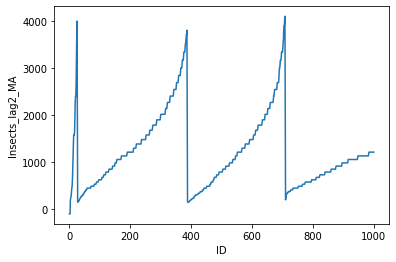

In [77]:
sns.lineplot(full_df.ID.loc[0:1000] , full_df.Insects_lag2_MA.loc[0:1000])

In [176]:
train = full_df.iloc[0:80000 , :]
test = full_df.iloc[80000: ,:]

In [174]:
train = new.iloc[0:80000 , :]
test = new.iloc[80000: ,:]

In [177]:
train_x = train.loc[:,train.columns!='Crop_status']
train_x.drop(columns = ['ID','is_train'],inplace = True)
# train_x['Category_of_Toxicant'] = train_x['Category_of_Toxicant'].astype('float64')
# train_x['Season'] = train_x['Season'].astype('float64')
train_y = train.loc[:,'Crop_status']
# train_y = train_y.astype('int64')
test.drop(columns = ['ID','Crop_status','is_train'],inplace = True)

In [178]:
# Sampling
crop_train_x , crop_val_x , crop_train_y , crop_val_y = train_test_split(train_x,train_y,test_size = 0.3, 
                                                                           stratify = train_y.values,random_state=498)

In [179]:
# Xgboost
from xgboost import XGBClassifier
xgc = XGBClassifier(n_jobs = -1 , n_estimators = 100)
xgc.fit(crop_train_x , crop_train_y)
valid_pred = xgc.predict(crop_val_x) ; train_pred = xgc.predict(crop_train_x)
valid_score = accuracy_score(valid_pred,crop_val_y) ; train_score = accuracy_score(train_pred, crop_train_y)
print(valid_score , train_score)
print(confusion_matrix(valid_pred, crop_val_y))

0.8805833333333334 0.8842142857142857
[[19664  1885   339]
 [  351  1470   291]
 [    0     0     0]]


In [104]:
len(xgc.feature_importances_),len(train_x.columns)

(56, 56)

In [105]:
fi = pd.DataFrame()

In [106]:
print(np.sort(xgc.feature_importances_))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00144153 0.00188228 0.00198286 0.00258851 0.00285329 0.00286865
 0.00318736 0.00367903 0.00410379 0.00475182 0.0057069  0.00637708
 0.00748128 0.00774756 0.00809867 0.00881473 0.00914841 0.00918761
 0.00928814 0.00957403 0.00989929 0.01020958 0.0109371  0.01129766
 0.01308365 0.01415501 0.01943429 0.02241303 0.02257734 0.02433651
 0.02463183 0.0283416  0.0381854  0.03852936 0.03956778 0.04058299
 0.04059156 0.04166532 0.04598174 0.04804333 0.05280159 0.05775134
 0.103155   0.13106415]


In [107]:
fi = pd.DataFrame({'features':list(train_x.columns),'FI':xgc.feature_importances_}).sort_values('FI',ascending = False)
fi.head()

,features,FI
39,Number_of_Weeks_Used_lag1_MA,0.131064
2,Soil,0.103155
3,Category_of_Toxicant,0.057751
35,Does_count_lag2,0.052802
32,Does_count_lag1,0.048043


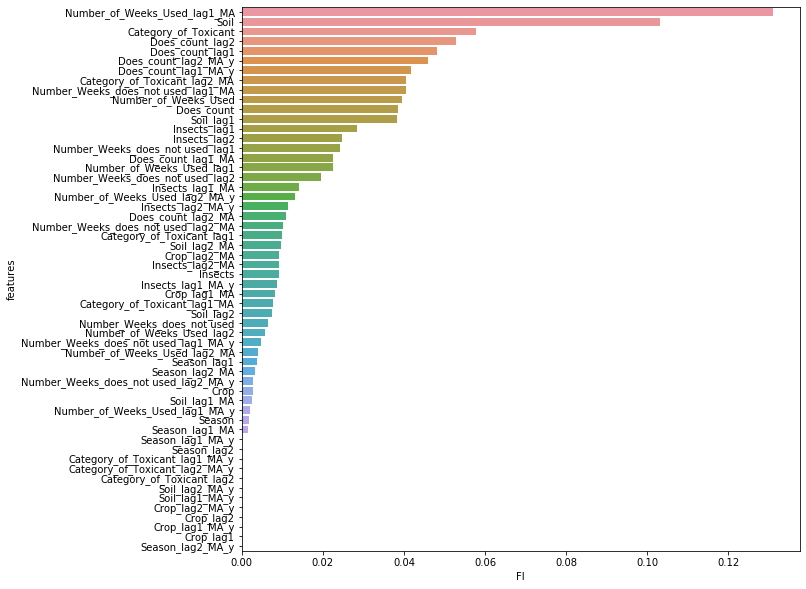

In [108]:
plt.figure(figsize = (10,10))
sns.barplot(fi.FI,fi.features,order = fi.sort_values('FI',ascending = False).features)

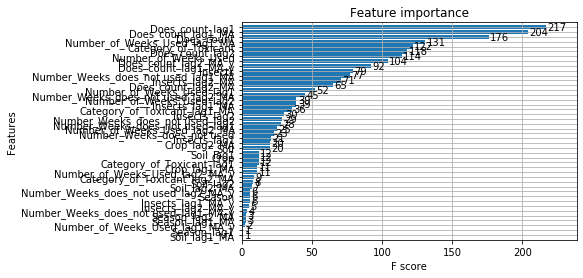

In [109]:
_ = plot_importance(xgc, height=0.9,)

In [123]:
weights = {0:0.5,1:0.8,2:1}

In [184]:
# LightGBM
lgb = LGBMClassifier(n_estimators = 500)
lgb.fit(crop_train_x , crop_train_y)
valid_pred = lgb.predict(crop_val_x) ; train_pred = lgb.predict(crop_train_x)
valid_score = accuracy_score(valid_pred,crop_val_y) ; train_score = accuracy_score(train_pred, crop_train_y)
print(valid_score , train_score)
print(confusion_matrix(valid_pred, crop_val_y))

0.9257083333333334 0.9789821428571429
[[19751   854   142]
 [  251  2445   467]
 [   13    56    21]]


In [327]:
pred_value = lgb.predict(test)
pred_value

array([1., 1., 1., ..., 0., 0., 0.])

In [328]:
set(pred_value)

{0.0, 1.0, 2.0}

In [333]:
len(pred_value)

35000

In [335]:
sub.head()

,ID,Crop_status
0,1.0,0.0
1,2.0,1.0
2,3.0,2.0
3,4.0,3.0
4,5.0,4.0


In [338]:
sub = sub.dropna()

In [339]:
sub.shape

(35000, 2)

In [340]:
sub['Crop_status'] = pred_value

In [341]:
excel = pd.ExcelWriter('crop1.xlsx')
sub.to_excel(excel)
excel.save()